# Chapter 14. Missing data and other opportunities

## Preamble

In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm
from pymc3.glm import GLM
import arviz as az
import rethinking
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import theano as tt
import warnings

In [4]:
plt.rcParams["figure.figsize"] = (20, 10)
warnings.filterwarnings("ignore", category=FutureWarning)   

## Chapter notes

### Measurement error

In [3]:
df = pd.read_csv("../external/rethinking/data/WaffleDivorce.csv", sep=";")
print(f"Data contains {len(df)} samples, each with {len(df.columns)} columns")
df.head()

Data contains 50 samples, each with 13 columns


,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [4]:
df["log(Population)"] = np.log(df["Population"])

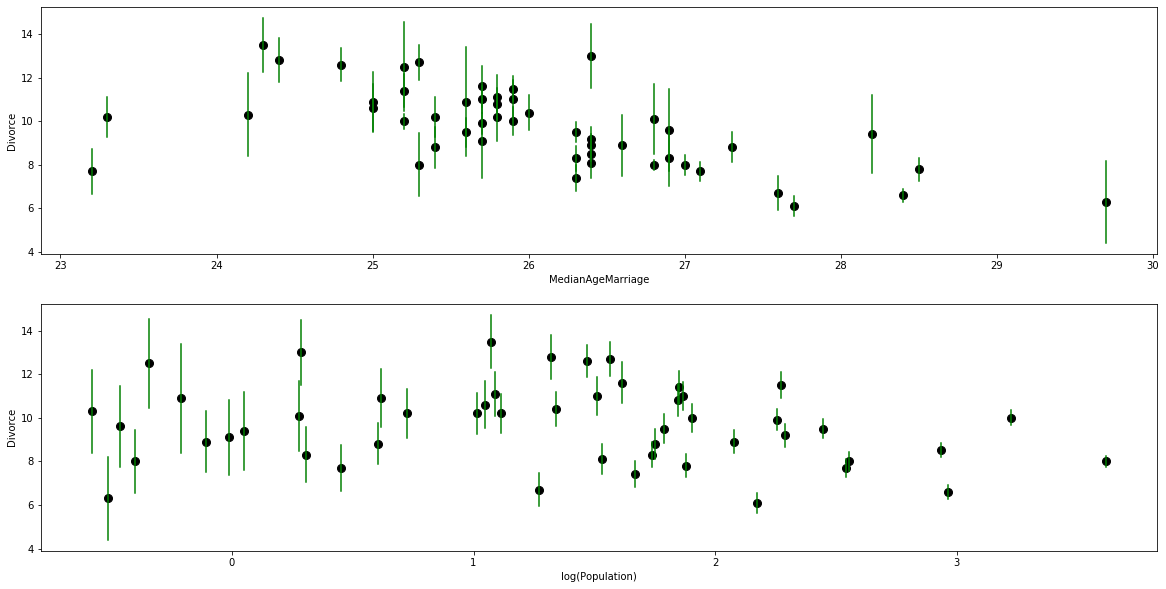

In [20]:
_, ax = plt.subplots(2, 1)
xlabels = ["MedianAgeMarriage", "log(Population)"]

for (i, xlabel) in enumerate(xlabels):
    ax[i].plot(df[xlabel], df.Divorce, "ko", markersize=8)
    ax[i].set_xlabel(xlabel)
    ax[i].set_ylabel("Divorce");
    for _, row in df.iterrows():
        x = row[xlabel]
        y1 = row["Divorce"] - row["Divorce SE"]
        y2 = row["Divorce"] + row["Divorce SE"]
        ax[i].plot([x, x], [y1, y2], color='g', linestyle='-')

In [23]:
models = {}
traces = {}

age = df["MedianAgeMarriage"].values
marriage = df["Marriage"].values
D_μ = df["Divorce"].values
D_σ = df["Divorce SE"].values
n_observations = len(D_μ)

with pm.Model() as model:
    σ = pm.HalfCauchy("σ", 2.5)
    β_R = pm.Normal("β_R", 0, 10)
    β_A = pm.Normal("β_A", 0, 10)
    α = pm.Normal("α", 0, 10)
    μ = α + β_A * age + β_R * marriage
    D_est = pm.Normal("D_est", μ, σ, shape=n_observations)
    pm.Normal("D_obs", D_est, D_σ, observed=D_μ, shape=n_observations)
models[0] = model 

In [24]:
kwargs = {"tune": 1000, "draws": 5000, "start": {"D_est": D_μ}, "target_accept": 0.9}
for (i, model) in models.items():
    if i not in traces:
        traces[i] = pm.sample(model=model, **kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [D_est, α, β_A, β_R, σ]
Sampling 4 chains, 71 divergences: 100%|██████████| 24000/24000 [03:05<00:00, 129.70draws/s]
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.


In [25]:
az.summary(traces[0])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
β_R,0.127,0.077,-0.017,0.270,0.001,0.000,14096.0,13829.0,14075.0,15443.0,1.0
β_A,-0.549,0.214,-0.958,-0.154,0.002,0.001,12704.0,12543.0,12696.0,14354.0,1.0
α,21.332,6.597,8.597,33.277,0.059,0.042,12543.0,12377.0,12537.0,14405.0,1.0
D_est[0],11.782,0.683,10.548,13.122,0.005,0.003,23015.0,22976.0,22978.0,11762.0,1.0
D_est[1],11.195,1.045,9.217,13.150,0.006,0.004,31965.0,30961.0,31823.0,14342.0,1.0
D_est[2],10.468,0.623,9.302,11.644,0.003,0.002,36344.0,36094.0,36377.0,15217.0,1.0
D_est[3],12.326,0.870,10.727,14.024,0.005,0.004,30568.0,30035.0,30662.0,14819.0,1.0
D_est[4],8.049,0.234,7.597,8.476,0.001,0.001,38011.0,37753.0,38053.0,13240.0,1.0
D_est[5],11.015,0.729,9.652,12.407,0.004,0.003,28957.0,28422.0,29057.0,14214.0,1.0
D_est[6],7.236,0.659,6.018,8.483,0.003,0.002,38656.0,38656.0,38776.0,14296.0,1.0


## Missing data

In [23]:
df = pd.read_csv("../external/rethinking/data/milk.csv", sep=";")
print(f"Data contains {len(df)} samples, each with {len(df.columns)} columns")
df.head()

Data contains 29 samples, each with 8 columns


,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [80]:
df["log_mass"] = np.log(df["mass"])

In [56]:
models = {}
traces = {}

In [57]:
warnings.filterwarnings("ignore", category=pm.ImputationWarning)  

neocortex = np.ma.masked_array(
    data=df["neocortex.perc"].values / 100,
    mask=np.isnan(neocortex),
    fill_value=np.nan)
log_mass = df["log_mass"].values
kcal = df["kcal.per.g"].values

with pm.Model() as model:
    α = pm.Normal("α", 0, 100)
    β_N = pm.Normal("β_N", 0, 10)
    β_M = pm.Normal("β_M", 0, 10)
    σ = pm.HalfCauchy("σ", 1)
    ν = pm.Normal("ν", 0.5, 1)
    σ_N = pm.HalfCauchy("σ_N", 1)
    N = pm.Normal("neocortex", ν, σ_N, observed=neocortex)
    μ = α + β_N * N + β_M * log_mass
    pm.Normal("kcal", μ, σ, observed=kcal)
models[0] = model 

In [58]:
kwargs = {"draws": 1000, "tune": 1000}
for (i, model) in models.items():
    if i not in traces:
        traces[i] = pm.sample(model=model, **kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [neocortex_missing, σ_N, ν, σ, β_M, β_N, α]
Sampling 4 chains, 44 divergences: 100%|██████████| 8000/8000 [00:22<00:00, 361.88draws/s]
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [59]:
az.summary(traces[0])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,-0.568,0.472,-1.436,0.354,0.017,0.012,808.0,808.0,814.0,1422.0,1.0
β_N,1.953,0.737,0.540,3.340,0.026,0.018,803.0,803.0,809.0,1362.0,1.0
β_M,-0.070,0.022,-0.112,-0.030,0.001,0.000,1164.0,1152.0,1168.0,1641.0,1.0
ν,0.671,0.014,0.645,0.697,0.000,0.000,1803.0,1798.0,1821.0,2189.0,1.0
neocortex_missing[0],0.631,0.048,0.542,0.722,0.001,0.001,2558.0,2558.0,2562.0,2357.0,1.0
neocortex_missing[1],0.623,0.051,0.525,0.715,0.001,0.001,2585.0,2552.0,2591.0,2314.0,1.0
neocortex_missing[2],0.621,0.052,0.527,0.725,0.001,0.001,2662.0,2635.0,2692.0,2323.0,1.0
neocortex_missing[3],0.651,0.047,0.559,0.736,0.001,0.001,3400.0,3393.0,3450.0,2649.0,1.0
neocortex_missing[4],0.701,0.049,0.611,0.792,0.001,0.001,3198.0,3157.0,3269.0,2591.0,1.0
neocortex_missing[5],0.655,0.050,0.562,0.750,0.001,0.001,2761.0,2728.0,2798.0,2293.0,1.0


In [76]:
df["neocortex.prop"] = df["neocortex.perc"] / 100
df["neocortex.prop"][np.isnan(neocortex)] = np.mean(traces[0]["neocortex_missing"], axis=0)

<ipython-input-76-a510681756ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["neocortex.prop"][np.isnan(neocortex)] = np.mean(traces[0]["neocortex_missing"], axis=0)
